In [76]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
import cv2
from google.colab.patches import cv2_imshow 
import numpy as np
from matplotlib import pyplot as plt



#Image Evaluation Metrices

In [78]:
!cp /content/drive/MyDrive/Colab\ Notebooks/CV_PROJECT_1/utils.py /content

In [79]:
from __future__ import absolute_import, division, print_function
import numpy as np
from scipy import signal
from math import log2, log10
from scipy.ndimage import generic_laplace,uniform_filter,correlate,gaussian_filter
from utils import _initial_check,_get_sigmas,_get_sums,Filter,_replace_value,fspecial,filter2,_power_complex,_compute_bef

In [80]:
def psnrb(GT, P):
	if len(GT.shape) == 3:
		GT = GT[:, :, 0]

	if len(P.shape) == 3:
		P = P[:, :, 0]

	imdff = np.double(GT) - np.double(P)

	mse = np.mean(np.square(imdff.flatten()))
	bef = _compute_bef(P) # calculates noise in the processed image
	mse_b = mse + bef

	if np.amax(P) > 2:
		psnr_b = 10 * log10(255**2/mse_b)
	else:
		psnr_b = 10 * log10(1/mse_b)

	return psnr_b

In [81]:
def _ssim_single (GT,P,ws,C1,C2,fltr_specs,mode):
	win = fspecial(**fltr_specs)

	GT_sum_sq,P_sum_sq,GT_P_sum_mul = _get_sums(GT,P,win,mode)
	sigmaGT_sq,sigmaP_sq,sigmaGT_P = _get_sigmas(GT,P,win,mode,sums=(GT_sum_sq,P_sum_sq,GT_P_sum_mul))

	assert C1 > 0
	assert C2 > 0

	ssim_map = ((2*GT_P_sum_mul + C1)*(2*sigmaGT_P + C2))/((GT_sum_sq + P_sum_sq + C1)*(sigmaGT_sq + sigmaP_sq + C2))
	cs_map = (2*sigmaGT_P + C2)/(sigmaGT_sq + sigmaP_sq + C2)

	
	return np.mean(ssim_map), np.mean(cs_map)
 

In [82]:
def ssim (GT,P,ws=11,K1=0.01,K2=0.03,MAX=None,fltr_specs=None,mode='valid'):
	if MAX is None:
		MAX = np.iinfo(GT.dtype).max

	GT,P = _initial_check(GT,P)

	if fltr_specs is None:
		fltr_specs=dict(fltr=Filter.UNIFORM,ws=ws)

	C1 = (K1*MAX)**2
	C2 = (K2*MAX)**2

	ssims = []
	css = []
	for i in range(GT.shape[2]):
		ssim,cs = _ssim_single(GT[:,:,i],P[:,:,i],ws,C1,C2,fltr_specs,mode)
		ssims.append(ssim)
		css.append(cs)
	return np.mean(ssims),np.mean(css)

## Colorization of Image


In [83]:
import numpy as np
import argparse
import cv2
import os

In [84]:
def axis_extension(image):
    stacked_img = np.stack((image,)*3, axis=-1)
    return stacked_img

In [85]:
def colorization(image):
      image=axis_extension(image)

      PROTOTXT = os.path.join(r"/content/drive/MyDrive/model/colorization_deploy_v2.prototxt")
      POINTS = os.path.join(r"/content/drive/MyDrive/model/pts_in_hull.npy")
      MODEL = os.path.join(r"/content/drive/MyDrive/model/colorization_release_v2.caffemodel")

      net = cv2.dnn.readNetFromCaffe(PROTOTXT, MODEL)
      pts = np.load(POINTS)

      class8 = net.getLayerId("class8_ab")
      conv8 = net.getLayerId("conv8_313_rh")
      pts = pts.transpose().reshape(2, 313, 1, 1)
      net.getLayer(class8).blobs = [pts.astype("float32")]
      net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]

      scaled = image.astype("float32") / 255.0
      lab = cv2.cvtColor(scaled, cv2.COLOR_BGR2LAB)

      resized = cv2.resize(lab, (224, 224))
      L = cv2.split(resized)[0]
      L -= 50

      net.setInput(cv2.dnn.blobFromImage(L))
      ab = net.forward()[0, :, :, :].transpose((1, 2, 0))

      ab = cv2.resize(ab, (image.shape[1], image.shape[0]))

      L = cv2.split(lab)[0]
      colorized = np.concatenate((L[:, :, np.newaxis], ab), axis=2)

      colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2BGR)
      colorized = np.clip(colorized, 0, 1)

      colorized = (255 * colorized).astype("uint8")

      return colorized

##SPATIAL DOMAIN FILTERS

Blur and Sharpen Filters


In [86]:
def blur_filter(original_image):
    M = 3
    blur_kernel = np.ones((M,M)) * 1/(M*M)
    blur_image = cv2.filter2D(src=original_image,  ddepth=-1,  kernel=blur_kernel)
    images.append(blur_image)
    return blur_image

In [87]:
def sharpen_filter(original_image):
    sharpen_kernel = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]], 
                          dtype=np.float32)
    sharpen_image = cv2.filter2D(src=original_image, ddepth=-1, kernel=sharpen_kernel )
    images.append(sharpen_image)
    return sharpen_image                                           

In [88]:
def axis_extension(image):
    stacked_img = np.stack((image,)*3, axis=-1)
    return stacked_img

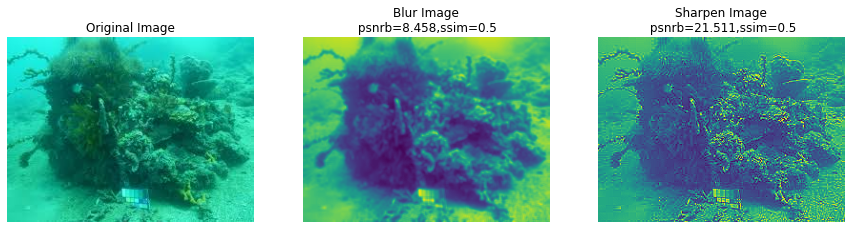

In [89]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
image = cv2.imread(r'/content/drive/MyDrive/images/1.jpeg')
f=image
images=[]
image_list=[]
image1 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
images.append(image1)

image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur_image=blur_filter(image)
sharpen_image=sharpen_filter(image)

x=psnrb(image1,blur_image)
x=round(x,3)
sharpen_image=axis_extension(sharpen_image)
y,z=ssim(image1,sharpen_image)
y=round(y,3)
A=f'Blur Image\n psnrb={x},ssim={round(y,3)}'
x=psnrb(f,blur_image)
x=round(x,3)
y,z=ssim(f,sharpen_image)
y=round(y,3)
B=f'Sharpen Image\n psnrb={round(x,3)},ssim={round(y,3)}'

title=['Original Image',A,B]

fig = plt.figure(figsize=(15, 10))
for i in range(len(title)):
    fig.add_subplot(1, 3, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(title[i])

Hisogram Equalisation

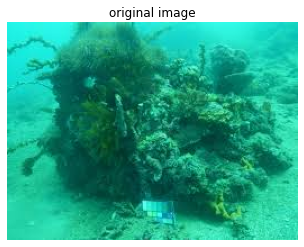

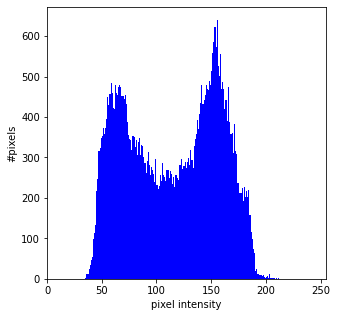

In [90]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# original image
f = cv2.imread(r'/content/drive/MyDrive/images/1.jpeg')
f1=f
image1 = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
plt.imshow(image1, cmap='gray')
plt.title('original image')
plt.axis('off')
plt.show()
f = cv2.cvtColor(f, cv2.COLOR_BGR2GRAY)
hist, bins = np.histogram(f.flatten(),bins=256, range=[0,256])
                                                  
cdf = hist.cumsum()
cdf_normalized = cdf / cdf.max()

fig, ax = plt.subplots(figsize=(5,5))

ax.hist(f.flatten(),bins=256,range=[0,256],color='b')
               
ax.set_xlabel('pixel intensity')
ax.set_ylabel('#pixels')
ax.set_xlim(0,255)
plt.show()

In [91]:
equ = cv2.equalizeHist(f)

output=colorization(equ)

cv2.imwrite("/content/drive/MyDrive/images/test/hist_equ.jpeg",output)
hist, bins = np.histogram(equ.flatten(), bins=256, range=[0,256])
                              
cdf = hist.cumsum()
cdf_normalized = cdf / cdf.max()

x=psnrb(f1,output)

y,z=ssim(f1,output)
plt.imshow(output, cmap='gray')
plt.title(f'Equalized image \n psnrb={round(x,3)},ssim={round(y,3)}')
plt.axis('off')
plt.show()

fig, ax = plt.subplots(figsize=(5,5))

ax.hist(equ.flatten(), bins=256,range=[0,256],color='b')         
ax.set_xlabel('pixel intensity')
ax.set_ylabel('pixels')
ax.set_xlim(0,255)
plt.show()

Clahe Filter

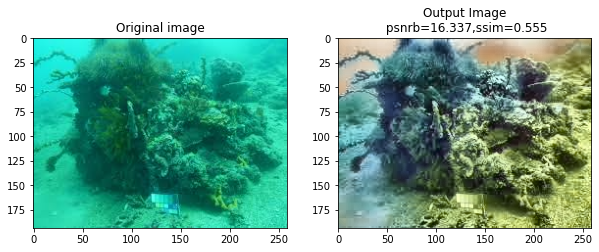

In [92]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

f = cv2.imread(r'/content/drive/MyDrive/images/1.jpeg')
f1=f
image1 = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
f= cv2.cvtColor(f, cv2.COLOR_BGR2GRAY)

clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
clahef = clahe.apply(f)

output=colorization(clahef)
hist, bins = np.histogram(clahef.flatten(), bins=256,  range=[0,256])
                                               
cdf = hist.cumsum()
cdf_normalized = cdf / cdf.max()
fig, ax = plt.subplots(figsize=(10,10))

x=psnrb(f1,output)
y,z=ssim(f1,output)

A=f'Output Image\n psnrb={round(x,3)},ssim={round(y,3)}'

images=[image1,output]
titles=['Original image',A]

for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(images[i],'gray')
    plt.title(titles[i])
plt.show()


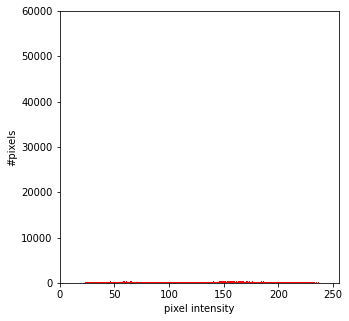

In [93]:
#clahe histogram
fig, ax = plt.subplots(figsize=(5,5))
ax.hist(clahef.flatten(),bins=256,range=[0,256],color='r')
           
ax.set_xlabel('pixel intensity')
ax.set_ylabel('#pixels')
ax.set_xlim(0,255)
ax.set_ylim(0,60000)
plt.show()

Laplacian Filter

In [ ]:
def laplacian_filter(image):
    image= cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = np.array([[0, 1, 0],
                      [1, -4, 1],
                      [0, 1, 0]])

    LaplacianImage = cv2.filter2D(src=image,ddepth=-1, kernel=kernel)
    c = -1
    img = image + c*LaplacianImage
    output=colorization(img)
    return output

In [94]:
import cv2
f = cv2.imread(r'/content/drive/MyDrive/images/1.jpeg')
output=laplacian_filter(f)
image1 = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)

x=psnrb(f,output)
y,z=ssim(f,output)

A=f'Output Image\n psnrb={round(x,3)},ssim={round(y,3)}'

images=[image1,output]
titles=['Original image',A]

plt.figure(figsize=(10,10))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(images[i],'gray')
    plt.title(titles[i])
plt.show()


High Boost Filter

In [ ]:
def unsharp_filter(f):
    f= cv2.cvtColor(f, cv2.COLOR_BGR2GRAY)
    k = 5
    f = f / 255
    f_blur = cv2.GaussianBlur(src=f, ksize=(31,31),sigmaX=0,sigmaY=0)
    g = f - f_blur  
    output = f + k*g
    return output  

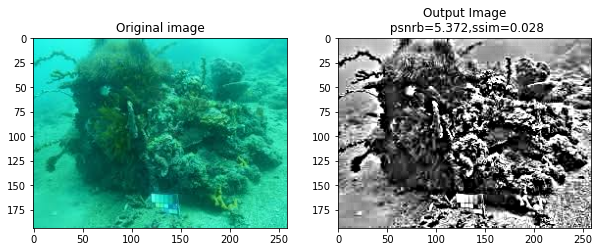

In [95]:
import cv2
f = cv2.imread(r'/content/drive/MyDrive/images/1.jpeg')
output=unsharp_filter(f)
image1 = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
output=axis_extension(output)

x=psnrb(f,output)
y,z=ssim(f,output)

A=f'Output Image\n psnrb={round(x,3)},ssim={round(y,3)}'
images=[image1,output]
titles=['Original image',A]

plt.figure(figsize=(10,10))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(images[i],'gray')
    plt.title(titles[i])
plt.show()


Bilateral Filter

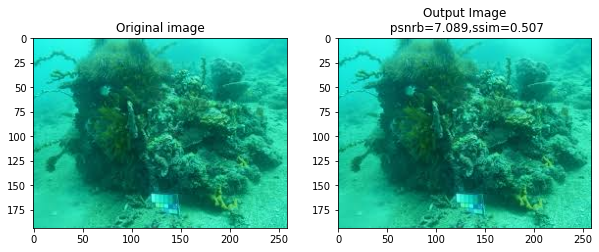

In [96]:
img = cv2.imread(r'/content/drive/MyDrive/images/1.jpeg')
  
bilateral = cv2.bilateralFilter(img,3, 2, 2)
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
bilateral = cv2.cvtColor(bilateral, cv2.COLOR_BGR2RGB) 

x=psnrb(img,bilateral)
y,z=ssim(img,bilateral)

A=f'Output Image\n psnrb={round(x,3)},ssim={round(y,3)}'
images=[img1,bilateral]
titles=['Original image',A]

plt.figure(figsize=(10,10))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(images[i],'gray')
    plt.title(titles[i])
plt.show()

Laplacian Pyramid

In [97]:
img = cv2.imread('/content/drive/MyDrive/images/3.jpeg')
levels = 8
pyramid = []
temp = img.copy()
for i in range(levels):
    down = cv2.pyrDown(temp)
    up = cv2.pyrUp(down)
    diff = cv2.subtract(temp, up)
    pyramid.append(diff)
    temp = down
# Apply a filter to the pyramid (for example, a sharpening filter)
kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
for i in range(levels):
    pyramid[i] = cv2.filter2D(pyramid[i], -1, kernel)
    pyramid[i] = cv2.normalize(pyramid[i], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
# Reconstruct the image from the filtered pyramid
temp = pyramid[-1]
for i in range(levels-2, -1, -1):
    up = cv2.pyrUp(temp)
    temp = cv2.add(pyramid[i], up)

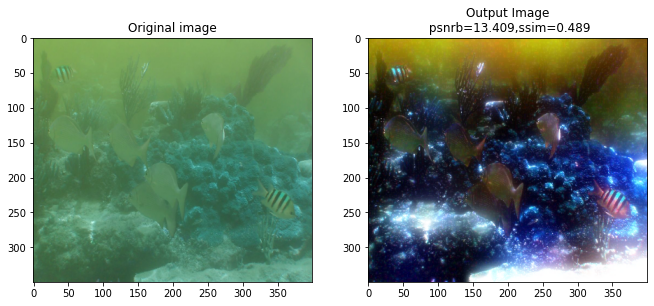

In [98]:
img=cv2.resize(img,(400,350))
temp=cv2.resize(temp,(400,350))
x=psnrb(img,temp)
y,z=ssim(img,temp)

A=f'Output Image\n psnrb={round(x,3)},ssim={round(y,3)}'
images=[img,temp]
titles=['Original image',A]

plt.figure(figsize=(11,10))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(images[i],'gray')
    plt.title(titles[i])
plt.show()

# FREQUENCY DOMAIN FILTERING


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [99]:
#@title Default title text
def spatial_to_freq(f):
  f=f/255
  F = np.fft.fftshift(np.fft.fft2(f))
  return F

In [100]:
def Laplacian_Filter(f):
    F=spatial_to_freq(f)
    P,Q = F.shape
    H = np.zeros((P,Q), dtype=np.float32)
    for u in range(P):
        for v in range(Q):
            H[u,v] = -4*np.pi*np.pi*((u-P/2)**2 + (v-Q/2)**2)
    return H,F

In [101]:
def convolution(H,F):
    Lap = H * F
    Lap = np.fft.ifftshift(Lap)
    Lap = np.real(np.fft.ifft2(Lap))
    OldRange = np.max(Lap) - np.min(Lap)
    NewRange = 1 - -1
    LapScaled = (((Lap - np.min(Lap)) * NewRange) / OldRange) + -1
    c = -1
    img = f + c*LapScaled
    img= np.clip(g, 0, 1)
    return img


Ideal Low Pass and High Pass Filters

In [102]:
def low_pass_filter(f):
  M,N = f.shape
  H = np.zeros((M,N), dtype=np.float32)
  D0 = 50
  for u in range(M):
      for v in range(N):
          D = np.sqrt((u-M/2)**2 + (v-N/2)**2)
          if D <= D0:
              H[u,v] = 1
          else:
              H[u,v] = 0
  return H

In [103]:
def high_pass_filter(f):
  M,N = f.shape
  H = np.zeros((M,N), dtype=np.float32)
  D0 = 50
  for u in range(M):
      for v in range(N):
          D = np.sqrt((u-M/2)**2 + (v-N/2)**2)
          if D <= D0:
              H[u,v] = 1
          else:
              H[u,v] = 0
  return 1-H

In [104]:
def convolution_with_filter(Fshift,H):
    Gshift = Fshift * H
    G = np.fft.ifftshift(Gshift)
    g = np.abs(np.fft.ifft2(G))
    g=colorization(g)
    return g


In [106]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

f = cv2.imread(r'/content/drive/MyDrive/images/1.jpeg')
f1=f
image1 = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
f = cv2.cvtColor(f, cv2.COLOR_BGR2GRAY)

F = np.fft.fft2(f)
Fshift = np.fft.fftshift(F)

lpf=low_pass_filter(f)
output1=convolution_with_filter(Fshift,lpf)
cv2.imwrite("/content/drive/MyDrive/images/test/ideal_lpf.jpeg",output1)

hpf=high_pass_filter(f)
output2=convolution_with_filter(Fshift,hpf)

x=psnrb(f1,output1)
x=round(x,3)
#s=axis_extension(output1)
y,z=ssim(f1,output1)
y=round(y,3)
A=f'Output Filter\n psnrb={x},ssim={round(y,3)}'

x=psnrb(f1,output2)
x=round(x,3)
#s=axis_extension(output2)
y,z=ssim(f1,output2)
y=round(y,3)

B=f'Output Filter\n psnrb={x},ssim={round(y,3)}'

images=[image1,lpf,output1,image1,hpf,output2]
titles=['Original image','Low pass Filter',A,'Original image','High pass Filter',A]

plt.figure(figsize=(15,10))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i],'gray')
    plt.title(titles[i])
plt.show()



ButterWorth High and Low Pass Filters

In [ ]:
def b_low_pass_filter(f):
    M,N = f.shape
    LPF= np.zeros((M,N), dtype=np.float32)
    D0 = 10 # cut of frequency
    n = 10 # order 
    for u in range(M):
        for v in range(N):
            D = np.sqrt((u-M/2)**2 + (v-N/2)**2)
            LPF[u,v] = 1 / (1 + (D/D0)**n)
    return LPF

In [ ]:
def b_high_pass_filter(f):
    M,N = f.shape
    HPF = np.zeros((M,N), dtype=np.float32)
    D0 = 10
    n = 10
    for u in range(M):
        for v in range(N):
            D = np.sqrt((u-M/2)**2 + (v-N/2)**2)
            HPF[u,v] = 1 / (1 + (D0/D)**n)
    return HPF

In [107]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

f = cv2.imread(r'/content/drive/MyDrive/images/1.jpeg')
image1 = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
f = cv2.cvtColor(f, cv2.COLOR_BGR2GRAY)

F = np.fft.fft2(f)
Fshift = np.fft.fftshift(F)

lpf=b_low_pass_filter(f)
output1=convolution_with_filter(Fshift,lpf)

hpf=b_high_pass_filter(f)
output2=convolution_with_filter(Fshift,hpf)

x=psnrb(f1,output1)
x=round(x,3)
#s=axis_extension(output1)
y,z=ssim(f1,output1)
y=round(y,3)
A=f'Output Filter\n psnrb={x},ssim={round(y,3)}'

x=psnrb(f1,output2)
x=round(x,3)
#s=axis_extension(output2)
y,z=ssim(f1,output2)
y=round(y,3)

B=f'Output Filter\n psnrb={x},ssim={round(y,3)}'

images=[image1,lpf,output1,image1,hpf,output2]
titles=['Original image','Low pass Filter',A,'Original image','High pass Filter',B]

plt.figure(figsize=(15,10))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i],'gray')
    plt.title(titles[i])
plt.show()



Guassian Low and High Pass Filters

In [ ]:
def g_low_pass_filter(f):
    M,N = f.shape
    H = np.zeros((M,N), dtype=np.float32)
    D0 = 10
    for u in range(M):
        for v in range(N):
            D = np.sqrt((u-M/2)**2 + (v-N/2)**2)
            H[u,v] = np.exp(-D**2/(2*D0*D0))
    return H

In [ ]:
def g_high_pass_filter(f):
    H=g_low_pass_filter(f)
    return 1-H

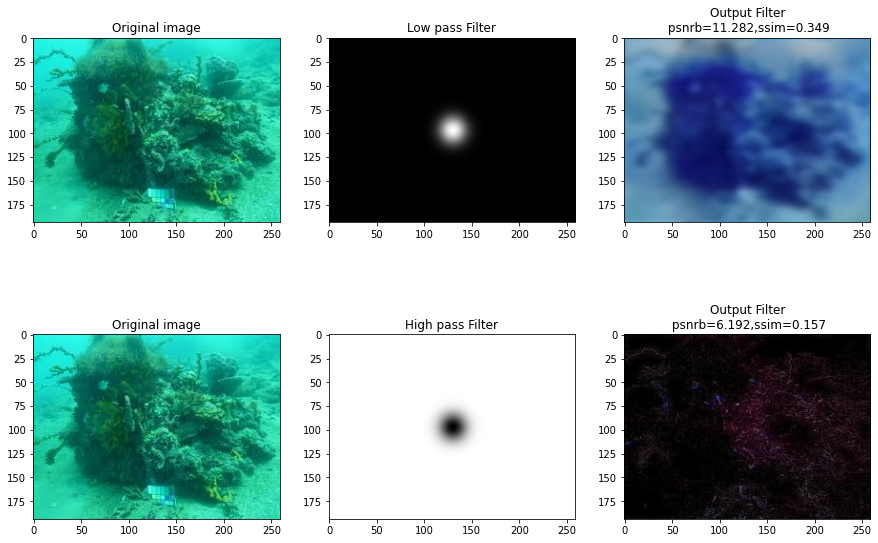

In [108]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

f = cv2.imread(r'/content/drive/MyDrive/images/1.jpeg')
image1 = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
f = cv2.cvtColor(f, cv2.COLOR_BGR2GRAY)

F = np.fft.fft2(f)
Fshift = np.fft.fftshift(F)

lpf=g_low_pass_filter(f)
output1=convolution_with_filter(Fshift,lpf)

hpf=g_high_pass_filter(f)
output2=convolution_with_filter(Fshift,hpf)

x=psnrb(f1,output1)
x=round(x,3)
#s=axis_extension(output1)
y,z=ssim(f1,output1)
y=round(y,3)
A=f'Output Filter\n psnrb={x},ssim={round(y,3)}'

x=psnrb(f1,output2)
x=round(x,3)
#s=axis_extension(output2)
y,z=ssim(f1,output2)
y=round(y,3)

B=f'Output Filter\n psnrb={x},ssim={round(y,3)}'

images=[image1,lpf,output1,image1,hpf,output2]
titles=['Original image','Low pass Filter',A,'Original image','High pass Filter',B]

plt.figure(figsize=(15,10))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i],'gray')
    plt.title(titles[i])
plt.show()



Homomorphic Filter

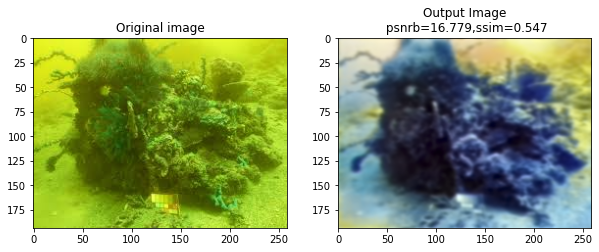

In [109]:
img=cv2.imread("/content/drive/MyDrive/images/1.jpeg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Take the logarithm of the image
gray_log = np.log1p(gray)

gray_fft = np.fft.fft2(gray_log)

gray_fft_shift = np.fft.fftshift(gray_fft)

d0 = 30
c = 1
n = 2

# Create a high-pass filter with the given parameters
rows, cols = gray.shape
crow, ccol = rows//2, cols//2
mask = np.zeros((rows, cols))
for i in range(rows):
    for j in range(cols):
        dist = np.sqrt((i-crow)**2 + (j-ccol)**2)
        mask[i, j] = (c + (dist/d0)**(2*n))**(-1)

# Apply the filter to the shifted Fourier Transform image
gray_filtered = np.real(np.fft.ifft2(np.fft.ifftshift(gray_fft_shift * mask)))

gray_exp = np.expm1(gray_filtered)
gray_norm = cv2.normalize(gray_exp, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

# Convert back to 8-bit image
gray_norm = np.uint8(gray_norm)
gray_norm1=colorization(gray_norm)

x=psnrb(img,gray_norm1)
y,z=ssim(img,gray_norm1)

A=f'Output Image\n psnrb={round(x,3)},ssim={round(y,3)}'
images=[img,gray_norm1]
titles=['Original image',A]

plt.figure(figsize=(10,10))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(images[i],'gray')
    plt.title(titles[i])
plt.show()

Wavelet Tranform

In [ ]:
import cv2
from google.colab.patches import cv2_imshow 
import numpy as np
from matplotlib import pyplot as plt
import pywt

In [ ]:
coeffs = pywt.dwt2(gray_norm, 'bior1.3')
cA, (cH, cV, cD) = coeffs
threshold = 30
cH_thresh = pywt.threshold(cH, threshold)
cV_thresh = pywt.threshold(cV, threshold)
cD_thresh = pywt.threshold(cD, threshold)

In [ ]:
coeffs_thresh = cA, (cH_thresh, cV_thresh, cD_thresh)
gray_thresh = pywt.idwt2(coeffs_thresh, 'bior1.3')
gray_norm = cv2.normalize(gray_thresh, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
gray_norm_eq = cv2.equalizeHist(np.uint8(gray_norm))
img_final = cv2.merge((gray_norm_eq, gray_norm_eq, gray_norm_eq))

In [110]:
# Display the result
img_final = cv2.cvtColor(img_final, cv2.COLOR_BGR2GRAY)
img_final=colorization(img_final)
img_final=cv2.resize(img_final,(260,180))
img=cv2.resize(img,(260,180))

x=psnrb(img,img_final)
y,z=ssim(img,img_final)

A=f'Output Image\n psnrb={round(x,3)},ssim={round(y,3)}'
images=[img,gray_norm1]
titles=['Original image',A]

plt.figure(figsize=(10,10))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(images[i],'gray')
    plt.title(titles[i])
plt.show()

# DENOISING OF IMAGE

In [ ]:
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import img_as_ubyte, img_as_float
from matplotlib import pyplot as plt
from skimage import io
import numpy as np
import cv2
from scipy import ndimage as nd

In [ ]:
def denoise(img):
  gaussian_img = nd.gaussian_filter(img, sigma=3)
  median_img = nd.median_filter(img, size=3)

  sigma_est = np.mean(estimate_sigma(img))
  patch_kw = dict(patch_size=5,  patch_distance=3)     
               
  denoise_img = denoise_nl_means(img, h=1.15 * sigma_est, fast_mode=False, patch_size=5, patch_distance=3)
                                                     
  denoise_img = img_as_ubyte(denoise_img)

  return denoise_img

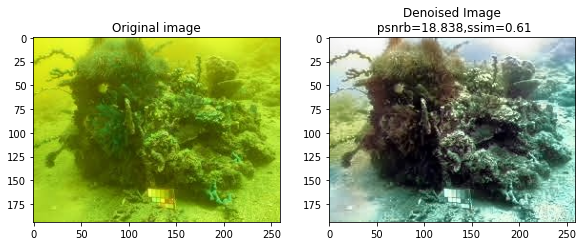

In [111]:
img3=cv2.imread("/content/drive/MyDrive/images/1.jpeg")
img1 = img_as_float(io.imread(r'/content/drive/MyDrive/images/test/hist_equ.jpeg'))# output of histogram equalized output is given as input

denoise_img=denoise(img1)
x=psnrb(img3,denoise_img)
x=round(x,3)
y,z=ssim(img3,denoise_img)
y=round(y,3)
cv2.imwrite("/content/drive/MyDrive/images/test/output_hist.jpeg",denoise_img)
B=f'Denoised Image\n psnrb={x},ssim={round(y,4)}'

images=[img3,denoise_img]
titles=['Original image',B]

plt.figure(figsize=(15,10))
for i in range(2):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i],'gray')
    plt.title(titles[i])
plt.show()

In [112]:
img2 = img_as_float(io.imread(r'/content/drive/MyDrive/images/test/ideal_lpf.jpeg'))# output of Ideal LPF output is given as input
img3=cv2.imread("/content/drive/MyDrive/images/1.jpeg")

denoise_img=denoise(img2)
x=psnrb(img3,denoise_img)
x=round(x,3)
y,z=ssim(img3,denoise_img)
cv2.imwrite("/content/drive/MyDrive/images/test/output_lpf.jpeg",denoise_img)
y=round(y,3)

B=f'Denoised Image\n psnrb={x},ssim={round(y,4)}'

images=[img3,denoise_img]
titles=['Original image',B]

plt.figure(figsize=(15,10))
for i in range(2):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i],'gray')
    plt.title(titles[i])
plt.show()

#NEURAL NETWORK

In [ ]:
import cv2
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import Model, Input, regularizers,Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from keras.optimizers import *

import glob
from tqdm import tqdm
import warnings;
warnings.filterwarnings('ignore')
from keras.preprocessing import image

In [113]:
images=[]

for i in tqdm(os.listdir('/content/drive/MyDrive/images/train/')):
  img=tf.keras.utils.load_img(os.path.join('/content/drive/MyDrive/images/train/',i),target_size=(64,64,3))
  img=tf.keras.utils.img_to_array(img)
  img=img/255.
  images.append(img)

100%|██████████| 12/12 [00:00<00:00, 210.78it/s]


In [114]:
train_x,test_x = train_test_split(np.array(images), random_state=102, test_size=0.2)

In [115]:
model=Sequential()
model.add(Conv2D(128, (3, 3),padding='same', activation='relu',input_shape=(64,64,3)))

model.add(Conv2D(64, (3, 3),padding='same', activation='relu'))
model.add(Conv2D(32, (3, 3),padding='same', activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(16, (3, 3),padding='same', activation='relu'))

In [116]:
model.add(Conv2D(16, (3, 3),padding='same', activation='relu'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(32, (3, 3),padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3),padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3),padding='same', activation='relu'))
model.add(Conv2D(3, (3, 3),padding='same', activation='relu'))

optimizer=Adam(lr=1e-3)
model.compile(loss='mean_squared_error',optimizer=optimizer,metrics=['accuracy'])

In [117]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 64, 64, 128)       3584      
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 64)        73792     
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 16)        4624      
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 16)        2320      
                                                      

In [118]:
model.fit(train_x, train_x, epochs=50, batch_size=5, shuffle=True)
model.save('autoencoder_100.h5')

Epoch 1/50
2/2 [==============================] - 7s 1s/step - loss: 0.2073 - accuracy: 0.2971
Epoch 2/50
2/2 [==============================] - 3s 1s/step - loss: 0.0495 - accuracy: 0.5146
Epoch 3/50
2/2 [==============================] - 2s 672ms/step - loss: 0.0415 - accuracy: 0.6489
Epoch 4/50
2/2 [==============================] - 1s 650ms/step - loss: 0.0458 - accuracy: 0.6489
Epoch 5/50
2/2 [==============================] - 2s 1s/step - loss: 0.0305 - accuracy: 0.6412
Epoch 6/50
2/2 [==============================] - 3s 1s/step - loss: 0.0262 - accuracy: 0.3684
Epoch 7/50
2/2 [==============================] - 2s 637ms/step - loss: 0.0269 - accuracy: 0.3162
Epoch 8/50
2/2 [==============================] - 1s 636ms/step - loss: 0.0242 - accuracy: 0.5130
Epoch 9/50
2/2 [==============================] - 1s 640ms/step - loss: 0.0221 - accuracy: 0.6482
Epoch 10/50
2/2 [==============================] - 1s 630ms/step - loss: 0.0229 - accuracy: 0.6488
Epoch 11/50
2/2 [==============

In [119]:
x=test_x
x.shape

(3, 64, 64, 3)

In [120]:
preds = model.predict(x)

1/1 [==============================] - 0s 226ms/step


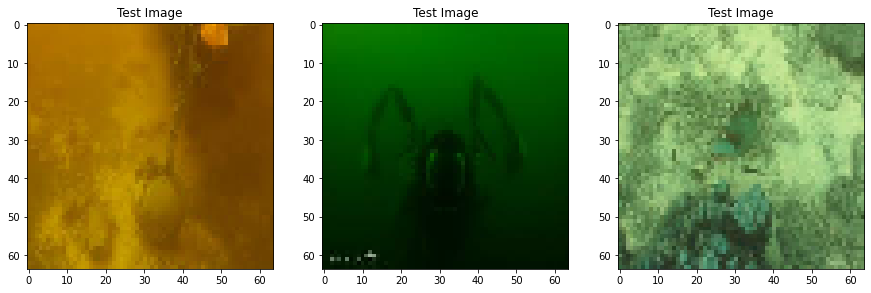

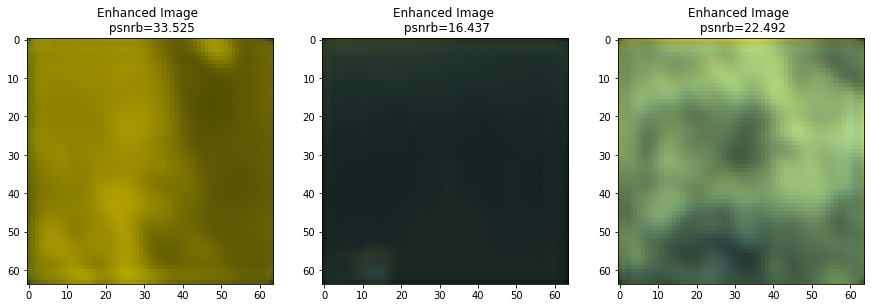

In [121]:
plt.figure(figsize=(15,10))
for i in range(3):
    plt.subplot(2,3,i+1)
    image1 = cv2.cvtColor(test_x[i], cv2.COLOR_BGR2RGB)
    plt.imshow(image1,'gray')
    plt.title('Test Image')
plt.show()
plt.figure(figsize=(15,10))
for i in range(3):
    plt.subplot(2,3,i+1)
    image2 = cv2.cvtColor(preds[i], cv2.COLOR_BGR2RGB)
    plt.imshow(image2,'gray')
    x=round(psnrb(test_x[i],preds[i]),3)
    A=f'Enhanced Image \n psnrb={x}'
    plt.title(A)
plt.show()